file paths

In [1]:
train_file = '/work/data/splits/splits_0.05/train.json'
val_file = '/work/data/splits/splits_0.05/val.json'
test_file = '/work/data/splits/splits_0.05/test.json'
import os

path_to_save = '/work/data/models2_6'
os.system(f'mkdir -p {path_to_save}')
path_to_res = '/work/data/results/2_6_2023_tp_graph_5re.txt'

import

In [2]:
%load_ext autoreload
%autoreload 2
import json
import dgl
from sklearn.metrics import f1_score
import torch as th
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.dataloading import GraphDataLoader
import torch.nn.functional as F
import networkx as nx
import warnings
from feature_extraction.base_featurizer import BaseFeaturizer
import torch
from graph_construction.tps_graph import create_dummy_dgl_graph, tps_graph
import numpy as np

from dgl_classifier.trainer import GraphDataset,snap_pred, tps_to_dgl, get_clasification_vec,\
tps_graph_const, extract_data, runner


import warnings

from preprocessing.utils import load_BGPS_from_json
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [3]:
#seed
dgl.seed(1223)

Model

In [4]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.RelGraphConv(in_dim, hidden_dim, 8)
        #self.conv1 = dglnn.GraphConv(in_dim, hidden_ˇdim)
        self.conv2 = dglnn.RelGraphConv(hidden_dim, hidden_dim, 8)
        #self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h, rel_types):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h, rel_types))
        h = F.relu(self.conv2(g, h, rel_types))
        with g.local_scope():
            g.ndata['node_features'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'node_features')
            return F.softmax( self.classify(hg), dim=1)
model = Classifier(113, 20, 2)

hyperparameters

In [5]:
early_stop =100
model = Classifier(113, 32, 2)
lr = 0.01
wd = 5e-4
epochs = 100

In [6]:
train_dataloader, val_dataloader, test_dataloader = extract_data(train_file, val_file, test_file, community_no=30, batch_size = 50, verbose=True)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return th.as_tensor(data, dtype=dtype)


# of catesian products: 36
# of catesian products: 10
# of catesian products: 13
# of predicate feats not in validation 47
# of predicate feats not in test 7
Training dataset size 250
Validation dataset size 86
Test dataset size 83


In [7]:
best_model_path = runner(train_dataloader,val_dataloader,test_dataloader,model, early_stop, lr, wd, epochs, path_to_res, path_to_save=path_to_save)

Epoch 1
--------------------------------------------------------------
Epoch:    1        1 Batch loss: 0.828641 Batch F1: 0.5294117647058824
Epoch:    1        2 Batch loss: 0.685826 Batch F1: 0.16666666666666666
Epoch:    1        3 Batch loss: 0.671124 Batch F1: 0.0
Epoch:    1        4 Batch loss: 0.660712 Batch F1: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch:    1        5 Batch loss: 0.648469 Batch F1: 0.3448275862068966
Train Avg Loss    1: 0.698955

Train Avg F1    1: 0.20818120351588912

Val Avg Loss    1: 0.250675

Val Avg F1    1:  0.6089417091114884

Optimal Val loss (Epoch 1): 0.2506752386689186

Epoch 2
--------------------------------------------------------------
Epoch:    2        1 Batch loss: 0.634208 Batch F1: 0.7391304347826089
Epoch:    2        2 Batch loss: 0.667082 Batch F1: 0.5714285714285713
Epoch:    2        3 Batch loss: 0.590475 Batch F1: 0.6666666666666667
Epoch:    2        4 Batch loss: 0.659385 Batch F1: 0.4827586206896552
Epoch:    2        5 Batch loss: 0.567330 Batch F1: 0.5384615384615385
Train Avg Loss    2: 0.623696

Train Avg F1    2: 0.5996891664058082

Val Avg Loss    2: 0.312101

Val Avg F1    2:  0.2721804511278195

Optimal Val loss (Epoch 1): 0.2506752386689186

Epoch 3
--------------------------------------------------------------
Epoch:    3        1 Batch loss: 0.584110 Batch F1: 0.4
Epoch

In [8]:
import json

In [9]:
results = json.load(open(path_to_res))

In [10]:
#print('best f1', np.max(results['val_f1']), np.argmax(results['val_f1']))
print('best f1 val', results['val_f1'][np.argmax(results['val_f1'])])
print('corr f1 train', results['train_f1'][np.argmax(results['val_f1'])])
print('corr f1 test', results['test_f1'][np.argmax(results['val_f1'])])
#print('best f1 train', np.max(results['train_f1']), np.argmax(results['train_f1']))

best f1 val 0.7526881720430108
corr f1 train 0.7312934441869974
corr f1 test 0.59


In [11]:
import matplotlib.pyplot as plt

(0.0, 1.0)

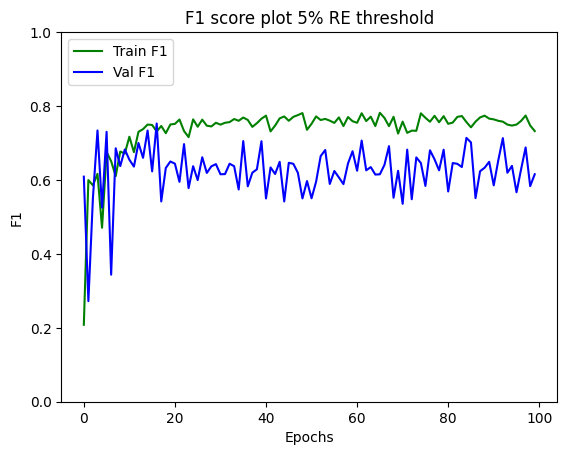

In [12]:
plt.title('F1 score plot 5% RE threshold')
plt.ylabel('F1')
plt.xlabel('Epochs')
plt.plot(results['train_f1'],'-g', label='Train F1')
plt.plot(results['val_f1'],'-b', label='Val F1')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

In [13]:
list(results.keys())

['train_loss',
 'val_loss',
 'test_loss',
 'train_f1',
 'val_f1',
 'test_f1',
 'train_prec',
 'val_prec',
 'test_prec',
 'train_recall',
 'val_recall',
 'test_recall']

(0.0, 1.0)

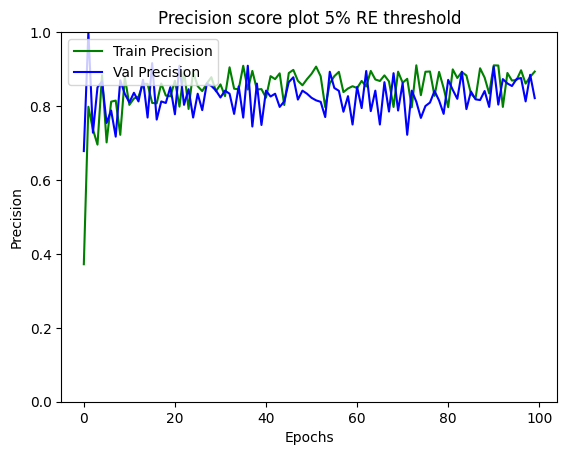

In [14]:
plt.title('Precision score plot 5% RE threshold')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.plot(results['train_prec'],'-g', label='Train Precision')
plt.plot(results['val_prec'],'-b', label='Val Precision')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

(0.0, 1.0)

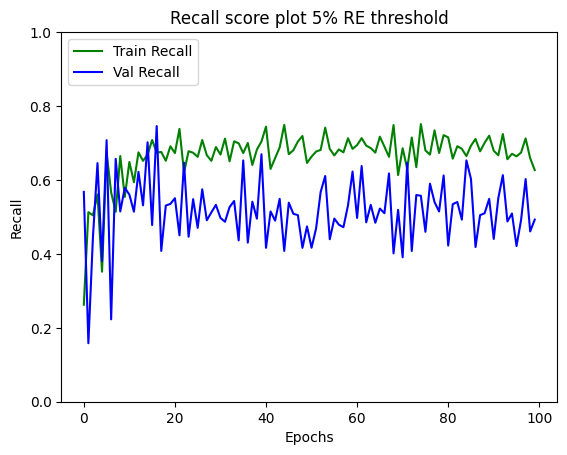

In [15]:
plt.title('Recall score plot 5% RE threshold')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.plot(results['train_recall'],'-g', label='Train Recall')
plt.plot(results['val_recall'],'-b', label='Val Recall')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

In [21]:
import torch
model = torch.load('/work/data/models2_6/best_f1_model_74.pt')
model.eval()
model

Classifier(
  (conv1): RelGraphConv(
    (linear_r): TypedLinear(in_size=113, out_size=32, num_types=8)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (conv2): RelGraphConv(
    (linear_r): TypedLinear(in_size=32, out_size=32, num_types=8)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (classify): Linear(in_features=32, out_features=2, bias=True)
)

In [22]:
from dgl_classifier. trainer import predict2samples
print(train_file)
train_data, val_data,test_data = predict2samples(model,train_file, val_file, test_file, community_no=10, verbose=True, clust_verbose=False, clust_load_path='/work/data/confs/May2/pred_clust.json')

/work/data/splits/splits_0.05/train.json


In [23]:
for k in train_data.keys():
    print(train_data[k])
    break

{'bloom_runtime': 0.087360461, 'jena_runtime': 0.084558884, 'gt': False, 'bgp_construction_duration': 5.4836273193359375e-05, 'tps_const_duration': 0.0002028942108154297, 'prediction': 1, 'inference_time': 0.005201816558837891}


In [24]:
from dgl_classifier.post import *
train_rt, avg_train = avg_runtime(train_data)
_,_, avg_train_jena,avg_train_blf = avg_runtime_type(train_data)
val_rt, avg_val = avg_runtime(val_data)
_,_, avg_val_jena,avg_val_blf = avg_runtime_type(val_data)
test_rt, avg_test = avg_runtime(test_data)
_,_, avg_test_jena,avg_test_blf = avg_runtime_type(test_data)

In [25]:
print('Train\n','\tWith Predictions ',round(avg_train,3),', Jena: ', round(avg_train_jena,3), ', Bloom Filter',round(avg_train_blf,3))
print('Validation\n','\tWith Predictions ',round(avg_val,3),', Jena: ', round(avg_val_jena,3), ', Bloom Filter',round(avg_val_blf,3))
print('Test\n','\tWith Predictions ',round(avg_test,3),', Jena: ', round(avg_test_jena,3), ', Bloom Filter',round(avg_test_blf,3))
#print(avg_val,avg_val_jena,avg_val_blf)
#print(avg_test,avg_test_jena,avg_test_blf)

3.287565739380094 3.759739541464 4.543417418276
5.972785981242262 6.664473213034885 7.355454263860466
3.8463032295911077 4.40134811313253 5.0240766965180725
